<a href="https://colab.research.google.com/github/sebastianT5/RL-Multi-Armed-Bandit/blob/main/Sebastian_Tejada_RL_Multi_Armed_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning



## Multi-Armed Bandit

Today, we're going to code the environment and basic strategies for the classic toy RL problem, the Multi-Armed Bandit.

https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/

https://cse442-17f.github.io/LinUCB

In [ ]:
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import random
from abc import ABC, abstractmethod

Implement the MultiArmedBandit Environment

In [ ]:
class MultiArmedBandit:
    """
    Multi-Armed Bandit environment.
    Each arm has a fixed but unknown probability of paying out a reward.
    """

    def __init__(self, n_arms, reward_probabilities: List =None):
        """
        Initialize the environment.
        :param n_arms: Number of arms in the bandit.
        :param reward_probabilities: List of probabilities for each arm to give a reward.
                                     If None, they are randomly generated.
        """
        self.n_arms = n_arms
        if reward_probabilities is None:
            self.reward_probabilities = np.random.rand(n_arms)
        else:
            if len(reward_probabilities) != n_arms:
                raise ValueError("Length of reward probabilities must match number of arms.")
            self.reward_probabilities = np.array(reward_probabilities)

    def pull(self, arm):
        """
        Simulate pulling an arm of the bandit.
        :param arm: The arm to pull.
        :return: The reward (1 for success, 0 for failure).
        """
        if arm < 0 or arm >= self.n_arms:
            raise ValueError("Invalid arm number.")
        return 1 if np.random.rand() < self.reward_probabilities[arm] else 0

# Example: Create a bandit with 5 arms
N_ARMS = 10
# REWARD_PROBS = [0, 0.2, 0.4, 0.6, 0.8]
bandit_env = MultiArmedBandit(n_arms=N_ARMS, reward_probabilities = None)

bandit_env.reward_probabilities  # Show the probabilities for demonstration purposes

array([0.31936257, 0.94567797, 0.11469712, 0.25430119, 0.82125682,
       0.28815432, 0.11606422, 0.64257145, 0.56732986, 0.82845218])

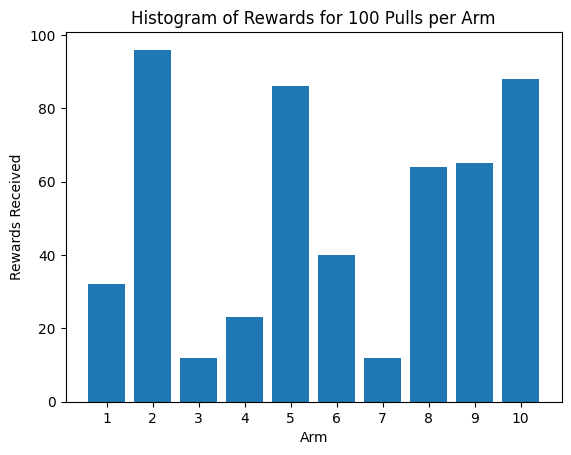

In [ ]:
def test_bandit_arms(bandit, pulls_per_arm):
    """
    Test each arm of the multi-armed bandit by pulling it a number of times and recording the total reward.
    :param bandit: The MultiArmedBandit instance.
    :param pulls_per_arm: Number of times to pull each arm.
    :return: List of sum of rewards received from each arm.
    """
    rewards = np.zeros(bandit.n_arms)
    for arm in range(bandit.n_arms):
        for _ in range(pulls_per_arm):
            rewards[arm] += bandit.pull(arm)
    return rewards

# Pull each arm of the bandit 100 times and record the rewards
pulls_per_arm = 100
arm_rewards = test_bandit_arms(bandit_env, pulls_per_arm)

# Plotting the histogram
plt.bar(range(1, bandit_env.n_arms + 1), arm_rewards)
plt.xlabel('Arm')
plt.ylabel('Rewards Received')
plt.title(f'Histogram of Rewards for {pulls_per_arm} Pulls per Arm')
plt.xticks(range(1, bandit_env.n_arms + 1))
plt.show()


## Random Strategy

In [ ]:
class BanditAgent(ABC):
    """
    Abstract class for a bandit agent.
    """

    def __init__(self, n_arms):
        """
        Initialize the bandit agent.
        :param n_arms: Number of arms in the bandit.
        """
        self.n_arms = n_arms

    @abstractmethod
    def select_arm(self):
        """
        Abstract method to select which arm to pull.
        Must be implemented by non-abstract subclasses.
        :return: Index of the selected arm.
        """
        pass

    @abstractmethod
    def update(self, chosen_arm, reward):
        """
        Abstract method to update the agent's state based on the last action and reward.
        Must be implemented by non-abstract subclasses.
        :param chosen_arm: The arm that was chosen.
        :param reward: The reward received from the chosen arm.
        """
        pass

class RandomBanditAgent(BanditAgent):
    """
    An example subclass of BanditAgent that selects arms randomly.
    """
    def select_arm(self):
      return random.randint(0, self.n_arms - 1)

    def update(self, chosen_arm, reward):
        # In a random agent, there's no need to update anything based on the reward.
        pass

# Example usage
n_arms = 5
random_agent = RandomBanditAgent(n_arms)
selected_arm = random_agent.select_arm()
selected_arm  # Show the randomly selected arm

4

In [ ]:
def eval_agent(env, agent, N = 1000):
  #Return the total reward achieved over N steps
  total_reward = 0
  for _ in range(N):
    selected_arm = agent.select_arm()
    reward = env.pull(agent.select_arm())
    total_reward += reward

    agent.update(selected_arm, reward)

  return total_reward

eval_agent(bandit_env, random_agent)

498

## Epsilon Greedy

Epsilon Greedy is a famous algorithm where epsilon of the time, the agent does something random (explores) and everytime else, the agent chooses the arm that has the highest empirical average

In [ ]:
class EpsilonGreedyBandit(BanditAgent):
    """
    An example subclass of BanditAgent that selects arms randomly.
    """
    def __init__(self, n_arms, eps):
        super().__init__(n_arms)

        self.eps = eps

        self.arm_avg_rewards = np.zeros(self.n_arms)
        self.arm_total_rewards = np.zeros(self.n_arms)
        self.num_arm_pulls = np.zeros(self.n_arms)

    def select_arm(self):
        if random.random() < self.eps or all(n == 0 for n in self.arm_avg_rewards):
          # Explore: randomly select an arm
          return random.randint(0, n_arms - 1)
        else:
          return np.argmax(self.arm_avg_rewards)

    def update(self, chosen_arm, reward):
        self.arm_total_rewards[chosen_arm] += reward
        self.num_arm_pulls[chosen_arm] += 1

        self.arm_avg_rewards[chosen_arm] = self.arm_total_rewards[chosen_arm] / self.num_arm_pulls[chosen_arm]

eps_agent = EpsilonGreedyBandit(5, 0.01)

In [ ]:
eval_agent(bandit_env, eps_agent, N = 10000)

9085

## Upper Confidence Bound (UCB) Strategy



Upper Confidence Bound agents is a strategy where you always pick the arm that has the highest upper confidence bound (which is a measure of its empirical average reward plus how uncertain you are about that arm)

You can read more about UCB here: https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/

The UCB value update algorithm is

UCB Value for arm i = Average reward for arm i + $\sqrt{c \cdot \frac{\ln(\text{total arm pulls})}{\text{arm pulls for arm i}}}$

In [ ]:
class UCBAgent(BanditAgent):
    """
    An example subclass of BanditAgent that selects arms randomly.
    """
    def __init__(self, n_arms, c = 2):
        super().__init__(n_arms)

        self.c = c

        self.arm_total_rewards = np.zeros(self.n_arms)
        self.num_arm_pulls = np.zeros(self.n_arms)

        self.ucb_values = np.full(n_arms, np.inf)

    def select_arm(self):
        if any(n == np.inf for n in self.ucb_values):
          #try every arm at least once
          indices = np.where(self.ucb_values == np.inf)[0]
          return random.choice(indices)
        else:
          return np.argmax(self.ucb_values)

    def update(self, chosen_arm, reward):
        self.arm_total_rewards[chosen_arm] += reward
        self.num_arm_pulls[chosen_arm] += 1

        self.ucb_values[chosen_arm] = (self.arm_total_rewards[chosen_arm] / self.num_arm_pulls[chosen_arm]) + np.sqrt(self.c * np.log(self.num_arm_pulls.sum()) / self.num_arm_pulls[chosen_arm])

ucb_agent = UCBAgent(5)
eval_agent(bandit_env, ucb_agent, N = 10000)

9157

## Comparing Agents

In [ ]:
import plotly.express as px


def reward_over_time(env, agent, N = 1000):
  #Return the total reward achieved over N steps
  total_reward = 0
  total_reward_over_time = []
  for _ in range(N):
    selected_arm = agent.select_arm()
    reward = env.pull(agent.select_arm())
    total_reward += reward

    agent.update(selected_arm, reward)
    total_reward_over_time.append(total_reward)

  return total_reward_over_time

random_rewards = reward_over_time(bandit_env, random_agent, N=1000)
epsilon_greedy_rewards = reward_over_time(bandit_env, eps_agent, N=1000)
ucb_rewards = reward_over_time(bandit_env, ucb_agent, N=1000)

# Create a DataFrame to store all the reward data
import pandas as pd
df = pd.DataFrame({
    'Random Agent': random_rewards,
    'Epsilon-Greedy Agent': epsilon_greedy_rewards,
    'UCB Agent': ucb_rewards
})

# Plotting
fig = px.line(df, labels={'index': 'Steps', 'value': 'Total Reward'},
              title='Total Reward Over Time for Different Agents')
fig.show()